# Head

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/Othercomputers/retep's PC/MambaVAE")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Mounted at /content/gdrive


In [ ]:
%pip install datasets

In [ ]:
%pip install causal_conv1d

# vae

In [ ]:
import torch, InitMamba, importlib
from datasets import load_from_disk
importlib.reload(InitMamba)
import VAE
importlib.reload(VAE)
from VAE import MambaVAE
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer
from data.Dataset import get_dataset, tokenizer

vae = MambaVAE().cuda().eval()
vae.load_state_dict(torch.load('./results/vae/model.pth', weights_only=True), strict=False)

dataset = load_from_disk("./data/CoT3")
# train_dataset, eval_dataset = get_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/517M [00:00<?, ?B/s]

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
id = 1
question_ids = torch.tensor([dataset[id]['question_ids']], device='cuda')
question_mask = torch.tensor([dataset[id]['question_mask']], device='cuda')
full_ids = torch.tensor([dataset[id]['full_ids']], device='cuda')
full_mask = torch.tensor([dataset[id]['full_mask']], device='cuda')
full_loss_mask = torch.tensor([dataset[id]['full_loss_mask']], device='cuda')
tokenizer.batch_decode(full_ids, skip_special_tokens=True)[0]

'<|startoftext|>Choose your reply from the options at the end. Does "The Tucson-Pima County Bicycle Advisory Committee (TPCBAC) serves in an advisory capacity to local governments on issues relating to bicycle recreation, transportation, and safety." contain the correct answer to "What organization advises the Tucson government on bike concerns?"\nOPTIONS:\n- yes\n- no<|thoughts|>The passage talks about the Tucson-Pima County Bicycle Advisory Committee serving in an advisory capacity to local governments on issues relating to bicycle recreation, transportation and safety. So, it does contain the correct answer for what organization advises the Tucson government on bike concerns. Hence, yes is our choice of reply<|answer|>yes'

In [ ]:
# input_ids, mask = question_ids, question_mask
# input_ids, mask = thoughts_ids, thoughts_mask
vae.eval()
state, log_var = vae.encode(full_ids, full_mask)

# idx = (state.abs() > 3)
# print(idx.sum() / state.numel())
# mix_state = state.clone()
# mix_state[idx] = torch.randn_like(state[idx])

res = vae.decode(state, full_ids, full_mask, full_loss_mask)
print(res.loss)
tokenizer.batch_decode(res.logits.argmax(-1), skip_special_tokens=True)

tensor(0.0489, device='cuda:0', grad_fn=<DivBackward0>)


['\n the answers the automatic\n the end of\n thisThe secondsonsonbasedho- Fairumpcle Festival Board isBBC))) is as the area committee for the government and the of to local ownership and bicy and and public.\n any correct answer to theWhat is doesises the userson- on issues safety?<|answer|>""IONS:\\\n- Yes\n- yesThe passage talks about the Tucson-Pima County Bicycle Advisory Committee serving in an advisory capacity to local governments on issues relating to bicycle recreation, transportation and safety. So, it does contain the correct answer for what organization advises the governmentson government on bike concerns. Hence, yes is our choice of response<|answer|>yes']

In [ ]:
r = 0.2
noise = torch.randn_like(state)
mix_state = (state*r**0.5+noise*(1-r)**0.5)

# idx = (state.abs() < 0.1)
# print(idx.sum() / state.numel())
# mix_state[idx] = torch.randn_like(state[idx]) * 0
vae.eval()
empty_ids = tokenizer('<|startoftext|>', return_tensors='pt').to('cuda')
tokens = vae.decoder.generate(input_ids = question_ids[:,:question_mask.sum()],
                inputs_ssm_states = vae.mlp2(mix_state),
                inputs_ssm_layer = 11,
                max_length = 256,
                # num_beams = 10
                )
tokenizer.batch_decode(tokens, skip_special_tokens=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-e9036d819510>", line 2, in <cell line: 0>
    noise = torch.randn_like(state)
            ^^^^^
NameError: name 'torch' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  

In [ ]:
import matplotlib.pyplot as plt
vae.train()
data_np = states.flatten().detach().cpu().numpy()
plt.hist(data_np, bins=50)
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-9233bd5d51f1>", line 2, in <cell line: 0>
    vae.train()
    ^^^
NameError: name 'vae' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
vae.sample(state, log_var)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-1f125c20efdc>", line 1, in <cell line: 0>
    vae.sample(state, log_var)
    ^^^
NameError: name 'vae' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
           ^^^^^^^^

# baseline


In [ ]:
import torch, transformers, os
from transformers import TrainingArguments, AutoTokenizer
from InitMamba import MambaForCausalLM
from datasets import load_dataset
import dataset.Dataset as Dataset

tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
model = MambaForCausalLM.from_pretrained('state-spaces/mamba-130m-hf').cuda()
dataset = load_dataset("arrow", data_files = './cache/CoT_full.arrow', split = 'train').select(range(100000))
print(dataset)
tot = len(dataset)
eval_size= int(tot * 0.05)
train_dataset = dataset.select(range(eval_size, tot))
eval_dataset = dataset.select(range(eval_size))
model.load_state_dict(torch.load("results/CoT_full/model.pth", weights_only=True))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
input_str = tokenizer.decode(eval_dataset[1]['input_ids'], skip_special_tokens=True)
input_ids = tokenizer(input_str.split(' Thinking: ')[0] + ' Thinking: ', return_tensors = 'pt')['input_ids'].cuda()
tokens = model.generate(
    input_ids,
    max_length = 512,
    # num_return_sequences = 5,
    # do_sample = False,
    # num_beams = 5
    )
print(input_str)
tokenizer.batch_decode(tokens)

# diffuser

In [ ]:
import importlib, torch
from datasets import load_from_disk
from VAE import MambaVAE
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer

dataset = load_from_disk("./data/CoT3")

tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
tokenizer.add_tokens(["<|startoftext|>", "<|thoughts|>", "<|answer|>"])

vae = MambaVAE().cuda().eval()
vae.load_state_dict(torch.load('./results/vae/model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
id = 2
question_ids = torch.tensor([dataset[id]['question_ids']], device='cuda')
question_mask = torch.tensor([dataset[id]['question_mask']], device='cuda')
full_ids = torch.tensor([dataset[id]['full_ids']], device='cuda')
full_mask = torch.tensor([dataset[id]['full_mask']], device='cuda')
full_loss_mask = torch.tensor([dataset[id]['full_loss_mask']], device='cuda')
tokenizer.batch_decode(full_ids, skip_special_tokens=True)

['<|startoftext|>You are given an original reference as well as a system generated reference. Your task is to judge the naturaleness of the system generated reference. If the utterance could have been produced by a native speaker output 1, else output 0.\n\nSystem Reference: there are no children allowed at hakkasan.\nOriginal Reference: sorry, hakkasan does not allow child -s.<|thoughts|>The system generated reference is grammatically correct and it is a valid response. Therefore, the answer is 1.<|answer|>1']

In [ ]:
import Diffuser, importlib, torch
importlib.reload(Diffuser)
from Diffuser import Diffuser

diff = Diffuser().cuda().eval()
del diff.vae
diff.load_state_dict(torch.load("results/denoiser.pth", weights_only=True))
diff.vae = vae

In [ ]:
res = diff(full_ids = full_ids, full_mask = full_mask, full_loss_mask = full_loss_mask,
     question_ids = question_ids, question_mask = question_mask)
print(res)

(tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>), tensor([668], device='cuda:0'), tensor([[ 0.7401,  1.5031, -0.0909,  ...,  0.1920, -0.3747, -0.0301]],
       device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[-0.0872,  0.2738,  0.0446,  ...,  0.2468,  0.0453,  0.3073]],
       device='cuda:0'))


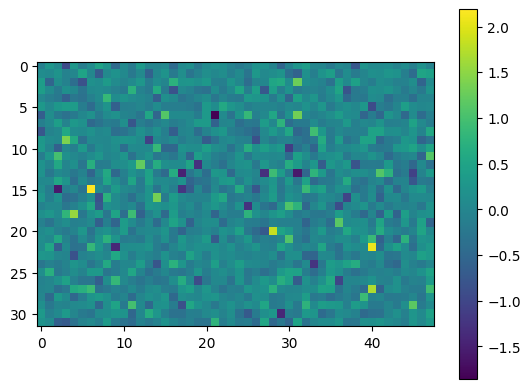

In [ ]:
import matplotlib.pyplot as plt

true_states = res[-1]

plt.imshow(true_states.unsqueeze(-1).reshape(32, 48).detach().cpu())
plt.colorbar()
plt.show()

In [ ]:
states = diff.generate(question_ids, question_mask, 100)
(states - true_states).pow(2).mean(),

100%|██████████| 100/100 [00:00<00:00, 732.33it/s]


(tensor(0.1644, device='cuda:0'),)

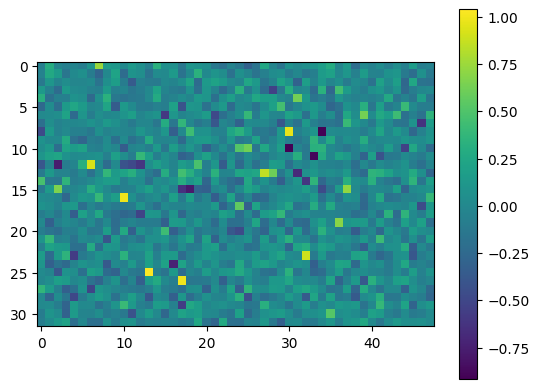

In [ ]:
import torch
import matplotlib.pyplot as plt

plt.imshow(states.reshape(32, 48).detach().cpu())
plt.colorbar()
plt.show()

In [ ]:
r = 1
tokens = vae.decoder.generate(input_ids = question_ids[:,:question_mask.sum()],
                inputs_ssm_states = vae.mlp2(torch.randn_like(states)*r**0.5 + states*(1-r)**0.5),
                inputs_ssm_layer = 11,
                max_length = 256,
                # do_sample=True,
                # num_return_sequences=3
                )
tokenizer.batch_decode(tokens, skip_special_tokens=True)

# Run

In [ ]:
!python data/Dataset.py

In [11]:
!python VAE_trainer.py

E0000 00:00:1743302678.294796   12830 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743302678.301019   12830 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Dataset({
    features: ['question_ids', 'question_mask', 'answer_ids', 'answer_mask', 'full_ids', 'full_mask', 'full_loss_mask'],
    num_rows: 1246019
})
The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.
{'----> logits_loss': 4.868440628051758, 'kl_loss': 102.3

In [ ]:
!python Baseline_trainer.py

In [ ]:
!python Diffuser_trainer.py

E0000 00:00:1743289037.986694    4922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743289037.993301    4922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Dataset({
    features: ['question_ids', 'question_mask', 'answer_ids', 'answer_mask', 'full_ids', 'full_mask', 'full_loss_mask'],
    num_rows: 1246019
})
The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.
  2% 38/2312 [00:21<17:05,  2.22it/s]Exception ignored in

In [ ]:
from google.colab import runtime
runtime.unassign()